<a href="https://colab.research.google.com/github/pachterlab/MBGBLHGP_2019/blob/master/notebooks/20ds_kallisto_cellranger_cmp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/pachterlab/MBGBLHGP_2019.git

Cloning into 'MBGBLHGP_2019'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 372 (delta 4), reused 16 (delta 3), pack-reused 354
Receiving objects: 100% (372/372), 241.40 MiB | 35.76 MiB/s, done.
Resolving deltas: 100% (142/142), done.
Checking out files: 100% (105/105), done.


In [2]:
!tar -xvf /content/MBGBLHGP_2019/data/colab_bus.tar.gz

colab_bus/
colab_bus/cellranger_filtered_SRR6998058_v2/
colab_bus/cellranger_filtered_SRR6998058_v2/matrix.mtx.gz
colab_bus/cellranger_filtered_SRR6998058_v2/features.tsv.gz
colab_bus/cellranger_filtered_SRR6998058_v2/barcodes.tsv.gz
colab_bus/cellranger_raw_SRR6998058_v2/
colab_bus/cellranger_raw_SRR6998058_v2/matrix.mtx.gz
colab_bus/cellranger_raw_SRR6998058_v2/features.tsv.gz
colab_bus/cellranger_raw_SRR6998058_v2/barcodes.tsv.gz
colab_bus/kallisto_SRR6998058_v2/
colab_bus/kallisto_SRR6998058_v2/run_info.json
colab_bus/kallisto_SRR6998058_v2/genes.barcodes.txt
colab_bus/kallisto_SRR6998058_v2/genes.genes.txt
colab_bus/kallisto_SRR6998058_v2/genes.mtx


In [3]:
pip install opentsne

     |████████████████████████████████| 2.3MB 4.3MB/s 


In [4]:
pip install anndata

     |████████████████████████████████| 122kB 4.2MB/s 


# Make the data

In [14]:
import anndata
import os
import pandas as pd
import scipy.io
import numpy as np
import datetime

import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances

from openTSNE.sklearn import TSNE
from openTSNE.callbacks import ErrorLogger

In [15]:
#@title Matrix functions
def import_adata(folder, cr=False):
    '''
        Returns adata with basic structure
    '''
    if cr:
        mat = os.path.join(folder, 'matrix.mtx.gz')
        var = os.path.join(folder, 'barcodes.tsv.gz')
        obs = os.path.join(folder, 'features.tsv.gz')
        bcs = pd.read_csv(var, index_col = 0, header = None, names = ['barcode'])
    else:
        mat = os.path.join(folder, 'genes.mtx')
        var = os.path.join(folder, 'genes.barcodes.txt')
        obs = os.path.join(folder, 'genes.genes.txt')
        bcs = pd.read_csv(var, index_col = 0, header = None, names = ['barcode'])



    if cr:
        gene = pd.read_csv(obs, header = None, index_col = 0, names =['ensembl_id', 'name', 'feature'], sep = '\t')
        gene.index = gene.index.str.slice(0, 18) # slice off the version number from the genes
        adata = anndata.AnnData(X=scipy.io.mmread(mat).tocsr(), obs=gene, var=bcs)
        adata.var.index = adata.var.index.str.slice(0,16,1) # slice the dump -1 off of the barcode
    else:

        gene = pd.read_csv(obs, header = None, index_col = 0, names =['ensembl_id'], sep = '\t')
        gene.index = gene.index.str.slice(0, 18) # slice off the version number from the genes
        adata = anndata.AnnData(X=scipy.io.mmread(mat).tocsr().T, obs=gene, var=bcs)

    del bcs, gene

    print(adata)

    return adata


def basic_process(A):
    '''
        Returns processed adata. obs["counts"] is the column sum
    '''

    adata = A.copy()

    adata.var['counts'] = np.array(adata.X.sum(0))[0]

    adata.var['ngenes'] = np.array((adata.X > 0).sum(0))[0]
    adata = adata[:,adata.var['counts'] > 0]

    adata.layers['log1p'] = np.log1p(adata.X)

    # adata.obs['log10counts'] = np.log10(adata.obs['counts'])

    print(adata)

    return adata

def filter_adata(A, B, obs=False, var=True, by_C=False):
    '''
        Ensures adata_1 and adata_2 have the same var and obs (optional). Filters by the index.
    '''

    adata_1 = A.copy()
    adata_2 = B.copy()

    if by_C:
        adata_1 = adata_1[:, adata_1.var.index.isin(adata_2.var.index)]
        # adata_1 = adata_1[adata_1.obs.index.isin(adata_2.obs.index)]
        return adata_1, adata_2
    if obs:
        adata_1 = adata_1[adata_1.obs.index.isin(adata_2.obs.index)]
        adata_2 = adata_2[adata_2.obs.index.isin(adata_1.obs.index)]
    if var:
        adata_1 = adata_1[:, adata_1.var.index.isin(adata_2.var.index)]
        adata_2 = adata_2[:, adata_2.var.index.isin(adata_1.var.index)]


    return adata_1, adata_2

# Correlations
def _sparse_M_std(X):
    n = X.shape[0]
    return np.sqrt(n * X.multiply(X).sum(0) - np.multiply(X.sum(0), X.sum(0)))

def sparse_M_corr(X, Y):
    '''
        Computes Pearson correlation between X and Y (both in sparse format). Must be same shape.
        X: A_raw[common_obs.index].layers['log1p'] # raw
        Y: B_raw[common_obs.index].layers['log1p']# raw
        X: A.layers['log1p'] # filtered
        Y: B.layers['log1p'] # filtered
        Notes: I changed the axis in sum and shape, need to check if right
    '''
    X_std = _sparse_M_std(X)
    Y_std = _sparse_M_std(Y)
    XY_std = np.multiply(X_std, Y_std)
    n = X.shape[0]
    XY_cov = n*X.multiply(Y).sum(0) - np.multiply(X.sum(0), Y.sum(0))
    R = np.divide(XY_cov, XY_std)
    return np.squeeze(np.asarray(R))

def l1_dist(X, Y):
    '''
        Computes l1 metric between X and Y. May need to modify since I swapped the rows and columns.
        X: A.layers['log1p']
        Y: B.layers['log1p']
    '''
    dist_AA = manhattan_distances(X, X)
    dist_AB = manhattan_distances(X, Y)

    # nkc are the kallisto-cellranger distances
    dist_AB = np.diagonal(dist_AB)

    # ncc are the kallisto-kallisto distances
    AA = []
    for row in dist_AA:
        val = np.partition(row, 1)[1]
        AA.append(val)
    dist_AA = AA

    return dist_AA, dist_AB

def MA(A, B):
    '''
        Computes MA for MA plot
        X: A.var["gene_count"]
        Y: B.var["gene_count"]
    '''
    X = np.array(A.X.mean(axis=1))[:,0]
    Y = np.array(B.X.mean(axis=1))[:,0]

    M_AB = np.log2(X + 1) - np.log2(Y + 1)
    A_AB = 0.5*(np.log2(X + 1) + np.log2(Y + 1))
    return A_AB, M_AB

def barcode_sets(A, B):
    '''
        Computes all, common, and individual barcode sets for two adatas A and B
    '''
    joint = A.var.join(B.var, how = 'outer', lsuffix='-A', rsuffix='-B')
    #joint = joint.fillna(0)

    common = A.var.join(B.var, how = 'inner', lsuffix='-A', rsuffix='-B')

    A_var = A.var.join(B.var, how = 'left', lsuffix='-A', rsuffix='-B')
    A_var = A_var.sort_values(by=['counts-A'], ascending = False)
    A_var = A_var[["counts-A", "ngenes-A"]].rename(columns={"counts-A":"counts", "ngenes-A":"ngenes"})

    B_var = B.var.join(A.var, how = 'left', lsuffix='-B', rsuffix='-A')
    B_var = B_var.sort_values('counts-A', ascending = False)
    B_var = B_var[["counts-B", "ngenes-B"]].rename(columns={"counts-B":"counts", "ngenes-B":"ngenes"})

    return joint, common, A_var, B_var

def compute_tsvd(A):

    adata = A.copy()

    tsvd = TruncatedSVD(n_components=10)
    TSVD = tsvd.fit_transform(adata.layers['log1p'].T)
    # print(TSVD.shape)
    adata.varm['TSVD'] = TSVD

    return adata

def compute_tsne(A):
    adata = A.copy()

    #tsne = TSNE(perplexity=30, metric="euclidean", callbacks=openTSNE.callbacks.ErrorLogger(),n_jobs=8, random_state=42, n_iter=750 )
    tsne = TSNE(perplexity=30, metric="euclidean", n_jobs=10, random_state=42, n_iter=750 )
    adata.varm['TSNE10'] = tsne.fit_transform(adata.varm['TSVD'])

    return adata

def T_sparse_M_std(X):
    n = X.shape[1]
    return np.sqrt(n * X.multiply(X).sum(1) - np.multiply(X.sum(1), X.sum(1)))
def T_sparse_M_corr(X,Y):
    X_std = T_sparse_M_std(X)
    Y_std = T_sparse_M_std(Y)
    XY_std = np.multiply(X_std, Y_std)
    n = X.shape[1]
    XY_cov = n* X.multiply(Y).sum(1) - np.multiply(X.sum(1), Y.sum(1))
    R = np.divide(XY_cov, XY_std)
    return np.squeeze(np.asarray(R))

In [16]:
A_folder = "/content/colab_bus/kallisto_SRR6998058_v2/"
B_folder = "/content/colab_bus/cellranger_raw_SRR6998058_v2/"
C_folder = '/content/colab_bus/cellranger_filtered_SRR6998058_v2/'

In [17]:
A = import_adata(A_folder)
B = import_adata(B_folder, cr=True)
C = import_adata(C_folder, cr=True)

A.obs_names_make_unique()
B.obs_names_make_unique()

A = A[:, A.var.sort_index().index]
A = A[A.obs.sort_index().index]

B = B[B.obs.sort_index().index]
B = B[:, B.var.sort_index().index]

A = basic_process(A)
B = basic_process(B)
C = basic_process(C)

AnnData object with n_obs × n_vars = 31053 × 116760
AnnData object with n_obs × n_vars = 31053 × 737280
    obs: 'name', 'feature'
AnnData object with n_obs × n_vars = 31053 × 575
    obs: 'name', 'feature'
AnnData object with n_obs × n_vars = 31053 × 110568
    var: 'counts', 'ngenes'
    layers: 'log1p'
AnnData object with n_obs × n_vars = 31053 × 108358
    obs: 'name', 'feature'
    var: 'counts', 'ngenes'
    layers: 'log1p'
AnnData object with n_obs × n_vars = 31053 × 575
    obs: 'name', 'feature'
    var: 'counts', 'ngenes'
    layers: 'log1p'


In [18]:
joint, common, A_var, B_var = barcode_sets(A, B)

In [19]:
Ap, Bp = filter_adata(A, B, obs=True, var=True)

In [20]:
Apf, C = filter_adata(Ap, C, by_C=True)
Bpf, C = filter_adata(Bp, C, by_C=True)
A_AB, M_AB = MA(Apf, Bpf)
cc_raw = T_sparse_M_corr(Ap[:,common.index].layers['log1p'].T, Bp[:,common.index].layers['log1p'].T)
cc_filtered = T_sparse_M_corr(Apf.layers['log1p'].T, Bpf.layers['log1p'].T)

In [21]:
Apf = compute_tsvd(Apf)
Bpf = compute_tsvd(Bpf)

In [22]:
Apf_final = compute_tsne(Apf)
Bpf_final = compute_tsne(Bpf)

In [23]:
Af = Apf_final
Bf = Bpf_final

In [24]:
dist_AA, dist_AB = l1_dist(Apf.layers['log1p'].T, Bpf.layers['log1p'].T)

In [25]:
dist_BB, dist_BA = l1_dist(Bpf.layers['log1p'].T, Apf.layers['log1p'].T)

# Plot the data

In [26]:
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable


label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

A_label = "kallisto"
B_label = "Cell Ranger"

dataset_shortname = 'ds'

In [32]:
#@title Plotting functions

fsize= 20
A_color = '#FF7F0E'
B_color = '#1F77B4'
dotsize = 10
xmax = 1e6
gridalpha = 0.2
mscale = 4.0

def _lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def _plt_color(lst):
    cols=[]
    for l in lst:
        if l>0.25 or l<-0.25:
            cols.append("red")
        elif l<=0.25 and l>=-0.25:
            cols.append('black')
    return cols


def knee_plot(A, ax=None,light=False, **kwargs):
    '''
        Makes knee plot.
        A: adata
        kwargs: [c = _lighten_color(B_color, 0.5), linewidth=2, alpha=1]
    '''
    if light:
        kwargs["c"] = _lighten_color(kwargs["color"], 0.5)
        del kwargs["color"]
        ranked_umi = np.sort(np.array(A.X.sum(0)), axis=None)[::-1]
        return ax.plot(ranked_umi, np.arange(len(ranked_umi)), **kwargs)
    #del kwargs["light"]

    ax = ax or plt.gca()

    if kwargs["label"] == "kallisto":
        ranked_umi = np.sort(np.array(A.X.sum(0)), axis=None)[::-1]
        return ax.plot(ranked_umi[0:A.X.shape[1]], np.arange(A.X.shape[1]), **kwargs)

    ranked_umi = np.sort(np.array(A.X.sum(0)), axis=None)[::-1]
    return ax.plot(ranked_umi, np.arange(len(ranked_umi)), **kwargs)

def knee_plot_settings(A, ax=None):
    ax = ax or plt.gca()

    ranked_umi = np.sort(np.array(A.var["counts"].values), axis=None)[::-1]
    ax.set_xscale('log')
    ax.set_xlim(1,xmax)
    ax.set_yscale("log", nonposy='clip')
    ax.set_xlabel('kallisto UMI counts',fontsize=fsize)
    ax.set_ylabel('Cumulative number of barcodes',fontsize=fsize)
    ax.set_title('',loc='center')
    ax.set_title('A', fontweight='bold', fontsize = fsize, loc = 'left' )
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    ax.axhline(y=np.shape(A.X)[1],linewidth=2, color='black', linestyle='--')
    ax.axvline(x=ranked_umi[np.shape(A.X)[1]-1],linewidth=2, color='black', linestyle='--')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], fontsize=fsize, markerscale=mscale, loc="upper right")
    return ax

def barcode_ratio_plot(A, B, joint, ax=None, **kwargs):
    ax = ax or plt.gca()

    ax.plot(np.geomspace(1,10e5,100),np.geomspace(1,10e5,100),'gray',linewidth=1 ) # identity line
    ax.scatter(joint['counts-A'].values, joint['counts-B'].values, color ='darkgray', s=dotsize, alpha=0.3, edgecolors = 'none', label = 'Discarded barcodes')
    ax.scatter(A.var['counts'].values, B.var['counts'].values, color ='black', s=dotsize, alpha=0.3, edgecolors = 'none', label = 'Retained barcodes')
    return ax

def barcode_ratio_plot_settings(ax=None):
    ax = ax or plt.gca()

    ax.set_xscale('log')
    ax.set_yscale("log", nonposy='clip')
    ax.set_xlabel('kallisto UMI counts',fontsize=fsize)
    ax.set_ylabel('Cell Ranger UMI counts',fontsize=fsize)
    ax.set_title('',loc='center')
    ax.set_xlim(1,xmax)
    ax.set_ylim(1,xmax)
    ax.set_title('B', fontweight='bold', fontsize = fsize, loc = 'left' )
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], fontsize=fsize, markerscale=mscale, loc="upper left")

    return ax

def genes_detected_plot(A, ax=None, light=False, **kwargs):
    ax = ax or plt.gca()

    if light:
        kwargs["c"] = _lighten_color(kwargs["c"], 0.3)

    return ax.scatter(A['counts'], A['ngenes'], **kwargs)

def genes_detected_plot_settings(ax=None):
    ax = ax or plt.gca()

    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = 0.5)
    ax.set_xscale('log')
    ax.set_xlim(1,xmax)
    ax.set_yscale("log", nonposy='clip')
    ax.set_ylabel('Genes detected',fontsize=fsize)
    ax.set_xlabel('kallisto UMI counts',fontsize=fsize)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    ax.set_title('C', fontweight='bold', fontsize = fsize, loc = 'left' )
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], fontsize=fsize, markerscale=mscale, loc="lower right")

    return ax

def cc_raw_plot(common, cc_raw, ax=None, **kwargs):
    ax = ax or plt.gca()

    ax.scatter(x = common["counts-A"], y = cc_raw, **kwargs)
    return ax

def cc_filtered_plot(A, cc_filtered, ax=None, **kwargs):
    ax = ax or plt.gca()

    ax.scatter(x = A.var['counts'], y = cc_filtered, **kwargs)
    return ax

def cc_plot_settings(ax=None):
    ax = ax or plt.gca()

    ax.set_xscale('log')
    ax.set_xlim(1,xmax)
    ax.set_ylim(0,1)
    ax.set_title('D', fontweight='bold', fontsize = fsize, loc = 'left')
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    ax.set_xlabel('kallisto UMI counts', fontsize = fsize)
    ax.set_ylabel('Pearson Correlation', fontsize = fsize)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], fontsize=fsize, markerscale=mscale, loc="lower right")
    return ax

def l1_plot(dist_AA, dist_AB, ax=None, **kwargs):
    ax = ax or plt.gca()

    hist, concat_bins = np.histogram(np.concatenate((dist_AA,dist_AB)), bins='auto')
    hist, ck_bins =  np.histogram(dist_AB, bins='auto')
    hist, cc_bins =  np.histogram(dist_AA, bins='auto')
    best_bins = min([ck_bins,concat_bins,cc_bins], key=len) # may need to change to max

    ax.hist(x=dist_AB, bins=best_bins, alpha=0.5, color = B_color, label="Closest Cell Ranger barcode")
    ax.hist(x=dist_AA, bins=best_bins, alpha=0.5, color = A_color, label="Closest kallisto barcode")
    return ax
def l1_plot_settings(ax=None):
    ax = ax or plt.gca()

    ax.set_xlabel('$\ell_1$ Distance', fontsize = fsize)
    ax.set_ylabel('Barcode counts', fontsize = fsize)
    ax.set_title('E', fontweight='bold', fontsize = fsize, loc = 'left' )
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc="upper right")

    return ax

def mod_l1_plot(counts, nkk, nck, ax_left, ax_right):
    nullfmt = NullFormatter()
    ax_right.yaxis.set_major_formatter(nullfmt)
    ax_left.scatter(counts, nkk, color=A_color, alpha=gridalpha)
    ax_left.scatter(counts, nck, color=B_color, alpha=gridalpha)
    binwidth = 0.25
    xymax = np.max([np.max(np.fabs(counts)), np.max(np.fabs(nkk))])
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(0, lim + binwidth, binwidth)

    hist, concat_bins = np.histogram(np.concatenate((nkk,nck)), bins='auto')
    hist, ck_bins =  np.histogram(nck, bins='auto')
    hist, cc_bins =  np.histogram(nkk, bins='auto')
    best_bins = min([ck_bins,concat_bins,cc_bins], key=len) # may need to change to max




    ax_right.hist(nkk, bins=best_bins, orientation='horizontal', color=A_color, label="kallisto", alpha=0.5)
    ax_right.hist(nck, bins=best_bins, orientation='horizontal', color=B_color, label="Cell Ranger", alpha=0.5)
    ax_right.legend(fontsize=fsize, loc="upper right")

    ax_right.set_ylim(ax_left.get_ylim())
    ax_right.set_xlabel("Barcode counts", fontsize=fsize)
    ax_left.set_xlabel("kallisto UMI counts", fontsize=fsize)
    ax_left.set_ylabel("$\ell_1$ Distance", fontsize=fsize)

    ax_left.set_title("E.1", fontweight='bold', fontsize = fsize, loc = 'left' )
    ax_right.set_title("E.2", fontweight='bold', fontsize = fsize, loc = 'left' )

    return ax_left, ax_right
def counts_l1_dist(counts, nkk, nck, ax):
    nullfmt = NullFormatter()
    ax.scatter(counts, nkk, color=A_color, alpha=gridalpha, label="kallisto", s=dotsize)
    ax.scatter(counts, nck, color=B_color, alpha=gridalpha, label="Cell Ranger", s=dotsize)
    ax.set_xlabel("kallisto UMI counts", fontsize=fsize)
    ax.set_ylabel("$\ell_1$ Distance", fontsize=fsize)

    ax.set_title("E.2", fontweight='bold', fontsize = fsize, loc = 'left' )
    ax.legend(fontsize=fsize, loc="upper left", markerscale=mscale)

    return ax

def tsne_plot(A, ax=None, **kwargs):
    ax = ax or plt.gca()

    ax.scatter(A.varm['TSNE10'][:,0], A.varm['TSNE10'][:,1], **kwargs)

    return ax

def tsne_plot_settings(title, ax=None):
    ax = ax or plt.gca()

    ax.set_ylabel(str(' t-SNE 2'), fontsize=fsize)
    ax.set_xlabel(str( 't-SNE 1'), fontsize=fsize)
    # loc.set_title('t-SNE on TSVD 10 components',fontweight='bold')
    ax.set_title(title, fontweight='bold', fontsize = fsize, loc = 'left' )
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.legend(fontsize=fsize, markerscale=mscale, loc="upper left")

    return ax

def MA_plot(A_AB, M_AB, ax=None, **kwargs):
    ax = ax or plt.gca()

    cols = _plt_color(M_AB)
    ax.scatter(A_AB, M_AB, alpha=0.1, c=cols)

    return ax

def MA_plot_settings(M_AB, ax=None):
    ax = ax or plt.gca()

    ax.set_ylabel("log$_2$(Fold change)", fontsize = fsize)
    ax.set_xlabel("log$_2$(Average gene count)", fontsize = fsize)
    ax.set_title('G.1', fontweight='bold', fontsize = fsize, loc = 'left' )
    ax.set_ylim(-5, 5)
    A_patch = mpatches.Patch(color=A_color, label="kallisto")
    B_patch = mpatches.Patch(color=B_color, label="Cell Ranger")
    same = mpatches.Patch(color='white', label='log$_2$(FC)$\leq$ 0.25 ({:.3f})'.format(M_AB[M_AB<=0.25].shape[0]/M_AB.shape[0]))
    ax.arrow(0, 1, 0, 1.5, length_includes_head=True, width=.05, color=A_color)
    ax.arrow(0, -1, 0, -1.5, length_includes_head=True, width=.05, color=B_color)
    ax.legend(handles=[A_patch, B_patch, same], fontsize=fsize, loc="upper right")
    return ax

def DE_plot(bar_path, go_terms_path, ax=None):
    ax = ax or plt.gca()

    df = pd.read_csv(bar_path)
    df["gene_set"] = df.gene_set.astype("str")

    try:
        GO_terms = pd.read_csv(go_terms_path, sep="\t", header=None)
    except:
        GO_terms = []



    fold_change_change_colors = {
    '(4,5]':_lighten_color(A_color, 1.4),
    '(3,4]':_lighten_color(A_color, 1.1),
    '(2,3]':_lighten_color(A_color, 0.8),
    '(1,2]':_lighten_color(A_color, 0.5),
    '(0,1]':_lighten_color(A_color, 0.2),
    '(-1,0]':_lighten_color(B_color, 0.2),
    '(-2,-1]':_lighten_color(B_color, 0.5),
    '(-3,-2]':_lighten_color(B_color, 0.8),
    '(-4,-3]':_lighten_color(B_color, 1.1),
    '(-5,-4]':_lighten_color(B_color, 1.4),
    }
    # For some datasets there are no DE genes, so we need this check to just write a text and make not plot
    if len(df)==0:
        ax.text(0.5*(1), 0.5*(1), 'No significant gene sets found ',
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=20, color='black',
            transform=ax.transAxes)
        ax.axis('off')

    # If there are DE genes, then we make a plot
    if len(df)>0:
        ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = 0.5)

        df = df[~df.gene_set.str.contains('nan')]
        genesets = np.sort(df.gene_set.unique())

        new = []
        for i in genesets:
            new.append(GO_terms.set_index(1).to_dict()[0][i])

        #print(genesets)
        changes = df.change.unique()
        changes = list(reversed(changes))
        changes_dict = {}
        for change_interval in changes:
            changes_dict[change_interval] = []
            for geneset in genesets:
                ngenes_found = np.sum(df.loc[df['gene_set']==geneset]['change']==change_interval)
                changes_dict[change_interval].append(ngenes_found)
        ind = [x for x, _ in enumerate(genesets)]
        ind = new
        bottom_list = [0]*len(genesets)
        for change_interval in changes_dict:
            ax.bar(ind, changes_dict[change_interval], bottom = bottom_list, label = change_interval,
                    alpha = 0.5, width=0.8, color = fold_change_change_colors[change_interval])
            bottom_list = np.array(bottom_list) + np.array(changes_dict[change_interval])

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], title='Fold change', fontsize=fsize, title_fontsize=fsize)


        ax.set_xticks(ticks=new)
        ax.set_xticklabels( labels=new)
        ax.set_ylabel("Number of genes", fontsize=fsize)
        ax.set_xlabel("Gene set", fontsize=fsize)
        for label in ax.get_xmajorticklabels():
            #label.set_rotation(30)
            label.set_horizontalalignment("right")

    ax.set_title('H', fontweight='bold', fontsize = fsize, loc = 'left' )
    return ax



def QQ_hgmm(dataset_shortname, path, ax):
    df = pd.read_csv(path)
    df.ontology = df.ontology.astype("category")

    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()

    from matplotlib.lines import Line2D
    hg = df[df.mapping.str.contains("Hs")]
    mm = df[df.mapping.str.contains("Mm")]
    legend_elements = [Line2D([0], [0], marker='o', color="w",alpha=0.4, label='Human',markerfacecolor='k', markersize=10),
                      Line2D([0], [0], marker='s', color='w', alpha=0.2, label='Mouse', markerfacecolor='grey', markersize=10)]

    #c = le.fit_transform(df.ontology.values)

    c = le.fit_transform(hg.ontology.values)
    scatter = ax.scatter(hg.uniform_log, hg.p_log, c=c)

    c = le.fit_transform(mm.ontology.values)
    ax.scatter(mm.uniform_log, mm.p_log, c=c, marker='s')

    l1 = ax.legend(handles=legend_elements, loc="lower right", title="Species", fontsize=fsize-5, title_fontsize=fsize-5)

    ax.plot(hg.uniform_log, hg.upper, color='k', alpha=0)
    ax.plot(hg.uniform_log, hg.lower, color='k', alpha=0)

    ax.plot(mm.uniform_log, mm.upper, color='grey', alpha=0)
    ax.plot(mm.uniform_log, mm.lower, color='grey', alpha=0)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.fill_between(hg.uniform_log, hg.lower, hg.upper, color='black', alpha='0.4')
    ax.fill_between(mm.uniform_log, mm.lower, mm.upper, color='grey', alpha='0.2')



    # Produce a legend for the ranking (colors). Even though there are 40 different
    # rankings, we only want to show 5 of them in the legend.

    l2 = ax.legend(*(scatter.legend_elements()[0], le.classes_), loc="upper left", title="Ontology", fontsize=fsize-5, title_fontsize=fsize-5)
    ax.add_artist(l1)


    ax.set_xlabel("Expected -log$_{10}$(p)", fontsize=fsize)
    ax.set_ylabel("Observed -log$_{10}$(p)", fontsize=fsize)
    df = df[df.label.astype(str).values != 'nan']
    with open("GO_"+dataset_shortname + ".txt", 'w') as f:


        for i, txt in enumerate(df["rank"]):
            f.write(str(i+1) + "\t" + df.label.values[i] + "\n")
            print(df.label.values[i])
            ax.annotate(txt, (df.uniform_log[i], df.p_log[i]), fontsize=15)
    ax.set_title("G.2", fontweight='bold', fontsize = fsize, loc = 'left' )
    return ax

def QQ_plot(dataset_shortname, path, ax):
    if "mm" in dataset_shortname:
        return QQ_hgmm(dataset_shortname, ax)

    df = pd.read_csv(path)
    df.ontology = df.ontology.astype("category")

    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()


    c = le.fit_transform(df.ontology.values)

    scatter = ax.scatter(df.uniform_log, df.p_log, c=c)


    ax.plot(df.uniform_log, df.upper, color='k', alpha=0)
    ax.plot(df.uniform_log, df.lower, color='k', alpha=0)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.fill_between(df.uniform_log, df.lower, df.upper, color='black', alpha=0.4)

    # Produce a legend for the ranking (colors). Even though there are 40 different
    # rankings, we only want to show 5 of them in the legend.

    l2 = ax.legend(*(scatter.legend_elements()[0], le.classes_), loc="best", title="Ontology", fontsize=fsize-5, title_fontsize=fsize-5)


    ax.set_xlabel("Expected -log$_{10}$(p)", fontsize=fsize)
    ax.set_ylabel("Observed -log$_{10}$(p)", fontsize=fsize)
    df = df[df.label.astype(str).values != 'nan']
    with open("GO_"+dataset_shortname + ".txt", 'w') as f:


        for i, txt in enumerate(df["rank"]):
            f.write(str(i+1) + "\t" + df.label.values[i] + "\n")
            print(df.label.values[i])
            ax.annotate(txt, (df.uniform_log[i], df.p_log[i]), fontsize=15)
    ax.set_title("G.2", fontweight='bold', fontsize = fsize, loc = 'left' )
    return ax

def make_hist(A, B, orientation="vertical", ax=None):
    hist, concat_bins = np.histogram(np.concatenate((A,B)), bins='auto')
    hist, A_bins =  np.histogram(A, bins='auto')
    hist, B_bins =  np.histogram(B, bins='auto')

    best_bins = min([A_bins,concat_bins,B_bins], key=len) # may need to change to max

    ax.hist(A, bins=best_bins, orientation=orientation, color=A_color, label="kallisto", alpha=1)
    ax.hist(B, bins=best_bins, orientation=orientation, color=B_color, label="Cell Ranger", alpha=1)
    return ax

def make_scatter_hist(dist_AA, dist_BB, dist_AB, dist_BA, ax=None):
    x = dist_AA
    y = dist_AB

    xx = dist_BA
    yy = dist_BB

    # the scatter plot:
    ax.scatter(x, y, label="kallisto", color=A_color)
    ax.scatter(xx, yy, label="Cell Ranger", color=B_color)
    ax.set_aspect(1.)

    # create new axes on the right and on the top of the current axes
    # The first argument of the new_vertical(new_horizontal) method is
    # the height (width) of the axes to be created in inches.
    divider = make_axes_locatable(ax)
    axHistx = divider.append_axes("top", 1.5, pad=0.075, sharex=ax)
    axHisty = divider.append_axes("right", 1.5, pad=0.075, sharey=ax)

    # make some labels invisible
    axHistx.xaxis.set_tick_params(labelbottom=False)
    axHisty.yaxis.set_tick_params(labelleft=False)


    ## Right histogram,  cellranger-cellranger, kallisto-cellranger,
    axHisty = make_hist(y, yy, orientation="horizontal", ax=axHisty)

    # kallisto-kallisto, cellranger-kallisto
    axHistx = make_hist(x, xx, orientation="vertical", ax=axHistx)


    # the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
    # thus there is no need to manually adjust the xlim and ylim of these
    # axis.
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.set_xlabel("$\ell_1$ to nearest kallisto", fontsize=fsize)
    ax.set_ylabel("$\ell_1$ to nearest Cell Ranger", fontsize=fsize)
    axHistx.set_ylabel("Barcode counts", fontsize=fsize-8)
    axHisty.set_xlabel("Barcode counts", fontsize=fsize-8)

    axHistx.set_title("E.1", fontweight='bold', fontsize = fsize, loc = 'left' )

    axHistx.legend(fontsize=fsize-5, loc="upper right")
    return axHistx

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


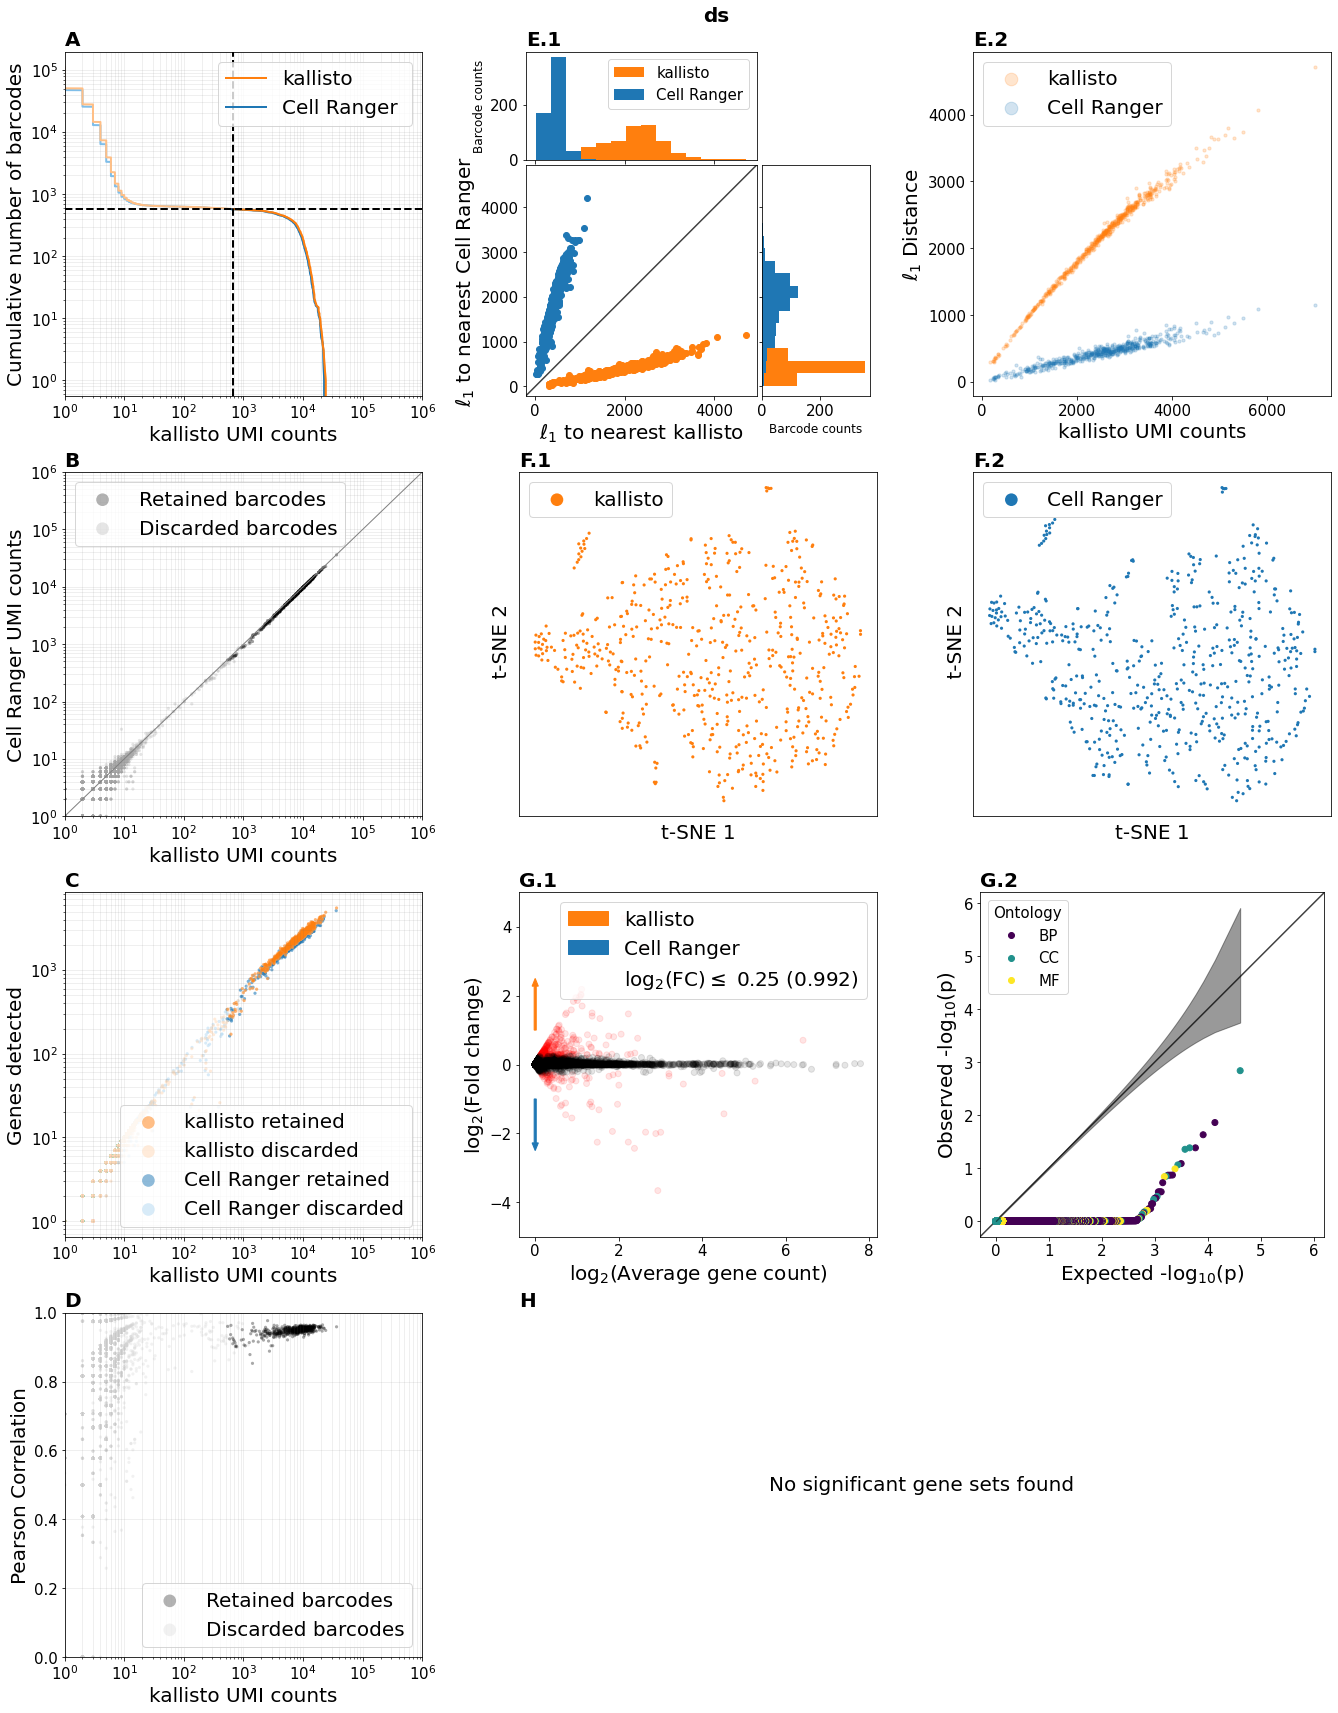

In [33]:
## Using GRIDSPEC
fig = plt.figure(figsize=(25, 25),constrained_layout=False)
st = fig.suptitle(dataset_shortname, fontweight='bold', fontsize = fsize, x=0.4)
gs = fig.add_gridspec(8, 4)

ax_a = fig.add_subplot(gs[0:2, 0])
ax_b = fig.add_subplot(gs[2:4, 0])
ax_c = fig.add_subplot(gs[4:6, 0])
ax_d = fig.add_subplot(gs[6:8, 0])

ax_e_left   = fig.add_subplot(gs[0:2, 1])
ax_e_right  = fig.add_subplot(gs[0:2, 2])

ax_f_left   = fig.add_subplot(gs[2:4, 1])
ax_f_right  = fig.add_subplot(gs[2:4, 2])
ax_g_left   = fig.add_subplot(gs[4:6, 1])
ax_g_right  = fig.add_subplot(gs[4:6, 2])
ax_h        = fig.add_subplot(gs[6:8, 1:3])

## Now we make the plots
# A ###  KNEE PLOT ##########
loc = ax_a
knee_plot(B, ax=loc, light=True, color=B_color, linewidth=2, alpha=1)
knee_plot(A, ax=loc, light=True, color=A_color, linewidth=2, alpha=1)
# knee_plot(Bf, ax=loc, color=B_color, linewidth=2, alpha=1, label=B_label)
# knee_plot(A, ax=loc, color=A_color, linewidth=2, alpha=1, label=A_label)
# knee_plot_settings(Af, ax=loc)


B_ranked_umi = np.sort(np.array(B.X.sum(0)), axis=None)[::-1]
loc.plot( B_ranked_umi[0:np.shape(Af.X)[1]], np.arange(np.shape(Af.X)[1]),
          color =B_color, linewidth=2, label = 'Cell Ranger ', alpha=1)
A_ranked_umi = np.sort(np.array(A.X.sum(0)), axis=None)[::-1]
loc.plot( A_ranked_umi[0:np.shape(Af.X)[1]], np.arange(np.shape(Af.X)[1]), color =A_color, linewidth=2, label ='kallisto', alpha=1)
loc.set_xscale('log')
loc.set_xlim(1,xmax)
loc.set_yscale("log", nonposy='clip')
loc.set_xlabel('kallisto UMI counts',fontsize=fsize)
loc.set_ylabel('Cumulative number of barcodes',fontsize=fsize)
loc.set_title('',loc='center')
loc.set_title('A', fontweight='bold', fontsize = fsize, loc = 'left' )
loc.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
loc.axhline(y=Af.X.shape[1],linewidth=2, color='black', linestyle='--')
loc.axvline(x=A_ranked_umi[Af.X.shape[1]],linewidth=2, color='black', linestyle='--')

handles, labels = loc.get_legend_handles_labels()
loc.legend(handles[::-1], labels[::-1], fontsize=fsize)
#knee_plot_settings(Af, ax=loc)

# B ###  BARCODE RATIOS PLOT ##########
loc = ax_b
barcode_ratio_plot(Af, Bf, joint, ax=loc)
barcode_ratio_plot_settings(ax=loc)

# C ### GENE VS UMI PLOT ####
loc = ax_c
genes_detected_plot(B_var,ax=loc,light=True,s=dotsize,alpha=0.5,c=B_color,edgecolors='none',label= B_label + ' discarded')
genes_detected_plot(Bf.var,ax=loc,light=False,s=dotsize,alpha=0.5,c=B_color,edgecolors='none',label=B_label + ' retained')
genes_detected_plot(A_var,ax=loc,light=True,s=dotsize,alpha=0.5,c=A_color,edgecolors='none',label=A_label + ' discarded')
genes_detected_plot(Af.var,ax=loc,light=False,s=dotsize,alpha=0.5,c=A_color,edgecolors='none',label=A_label + ' retained')
genes_detected_plot_settings(ax=loc)

# D ### CORRELATION PLOT ####
loc = ax_d
cc_raw_plot(common,cc_raw,ax=loc,s=dotsize,c='lightgray',alpha=0.3,edgecolors='none',label='Discarded barcodes')
cc_filtered_plot(Af,cc_filtered,ax=loc,s=dotsize,c='black',alpha=0.3,edgecolors='none',label='Retained barcodes')
cc_plot_settings(ax=loc)

# E ### BARCODE DISTANCE PLOT ####
# loc = ax_e
cnts = np.asarray(Af.layers["log1p"].sum(0))[0]

make_scatter_hist(dist_AA, dist_BB, dist_AB, dist_BA, ax=ax_e_left)
counts_l1_dist(cnts, dist_AA, dist_AB, ax_e_right)

# l1_plot(dist_AA, dist_AB, ax=loc)
# l1_plot_settings(ax=loc)

# F ###  A t-SNE ##########
loc = ax_f_left
tsne_plot(Af, ax=loc, s =10, c = A_color, alpha = 1, edgecolors = 'none', label = A_label )
tsne_plot_settings("F.1", ax=loc)

# F ### CellRanger t-SNE #############
loc = ax_f_right
tsne_plot(Bf, ax=loc, s =10, c = B_color, alpha = 1, edgecolors = 'none', label = B_label )
tsne_plot_settings("F.2", ax=loc)

# G LEFT ### MA Plot #################
loc = ax_g_left

MA_plot(A_AB, M_AB, ax=loc)
MA_plot_settings(M_AB, ax=loc)

# G RIGHT ## QQ PLOT
loc = ax_g_right
QQ_plot(dataset_shortname, "/content/MBGBLHGP_2019/data/SRR6998058_v2-GSEA-QQ.csv", ax=loc)


# H ##### DE PLOT #########
loc = ax_h
DE_plot("/content/MBGBLHGP_2019/data/SRR6998058_v2-GSEA-BAR.csv", "/content/MBGBLHGP_2019/data/GO_SRR6998058_v2.txt", ax=loc)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.925)
# plt.savefig(save + dataset_shortname + '.png', dpi=300, bbox_inches='tight')
#print(dataset_shortname + "saved.")
plt.show()